# Logistic Regression On Amazon Fine Food Reviews
###### This is my 5th assignment.

## Objective:

     1. Apply the Logistic Regression algorithm on BOW,TF-IDF,Word2Vec, TF-IDF Word2Vec
     2. Apply the both GridSearch and RandomSearch cross validation
     3. Evaluate differnet metrics such as precision ,recall,f1-score and plot the confusion matrix
     4. Show how sparsity increase as lambda increase or C decreases with L1 regularizer
     5. Use Pertubation to check for the multicolinerity of features


In [1]:
#Loading important Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer

E:\PYTHON\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
filtered_data=pd.read_csv('Reviews.csv')#displaying
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#For setting positive/negative 
filtered_data=pd.read_csv('Reviews.csv')
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
#pdb.set_trace()
positiveNegative = actualScore.map(partition) 
#pdb.set_trace()
filtered_data['Score'] = positiveNegative
#print(filtered_data.head())#print 5 row 
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,)

In [5]:
sorted_data=sorted_data[sorted_data.HelpfulnessNumerator<=sorted_data.HelpfulnessDenominator]
print(sorted_data.shape)

(568452, 10)


In [6]:
#De-duplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

print(final.shape)#shape

print((final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)#percentage

#get to know how much posive negative there in table
final['Score'].value_counts()

(393931, 10)
69.29865917031105


positive    336824
negative     57107
Name: Score, dtype: int64

In [7]:
###Sorting as we want according to time series

n_samples = 150000
df_sample = final.sample(n_samples)

df_sample.sort_values('Time',inplace=True)
df_sample.head(5)
#print(df_sample.shape)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
451902,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,positive,959990400,Research,I'm getting crazy.<p>Is it really impossible t...
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,This was a really good idea and the final prod...
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...


In [8]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stopwords = stopwords.words('english')#choosen the english language

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer,SnowballStemmer

stop = set(stopwords.words('english')) #set of stopwords
porter = PorterStemmer()
snowball = SnowballStemmer('english')
#Text Preprocessing: Stemming, stop-word removal and Lemmatization
# find sentences containing HTML tags
import re#regular expression

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;



0
In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


In [9]:
%%time
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

final_150000 = df_sample.head(150000)#taking 150000 datapoints

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

    str1=[];

for sent in final_150000['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    sent=cleanpunc(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(snowball.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_150000['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final_150000['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    #str1 =b" ".join(filtered_sentence) #final string of cleaned words
    str1 =b' '.join(filtered_sentence).decode()
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

Wall time: 7min 17s


In [10]:
#adding a column of CleanedText which displays the data after pre-processing of the review 
final_150000['clean_text']=final_string

#final_50000=final_100000.head(150000)#taking 50k datapoints
print(final_150000.shape)

(150000, 11)


In [11]:
#Functions to save objects for later use and retireve it
import pickle
def SaveToFile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def OpenFromFile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

## Bag Of Words Using Logistic Regression

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(final_150000['clean_text'].values,
                                                    final_150000['Score'].values ,test_size=0.30,shuffle=False)

In [66]:
#Preprocessing data

#Preprocessing data

uni_gram = CountVectorizer()

uni_gram.fit(X_train)
X_train=uni_gram.transform(X_train)
X_test = uni_gram.transform(X_test) 

X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (105000, 38523)
Test Data Size:  (45000, 25611)


In [67]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):

    # print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(9550, 38523) (9545, 38523)
(19095, 38523) (9545, 38523)
(28640, 38523) (9545, 38523)
(38185, 38523) (9545, 38523)
(47730, 38523) (9545, 38523)
(57275, 38523) (9545, 38523)
(66820, 38523) (9545, 38523)
(76365, 38523) (9545, 38523)
(85910, 38523) (9545, 38523)
(95455, 38523) (9545, 38523)


### Find the best C value

In [27]:
%%time
from sklearn.model_selection import GridSearchCV # Finding the best "Alpha" using forward chaining cross validation
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
param_grid ={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005
                  ,0.001,0.0005,0.0001],'penalty':['l1','l2']} #params we need to try on classifier

tscv = TimeSeriesSplit(n_splits=10) #For time based splitting

grid = GridSearchCV(LR, param_grid, cv=tscv, verbose=1)# instantiate the grid
grid.fit(X_train,y_train)

SaveToFile(grid,"LR-Uni-Gram")
print("Best HyperParameter: ",grid.best_params_)
print("Best Accuracy: %.2f%%"%(grid.best_score_*100))


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 25.9min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 90.71%
Wall time: 26min 7s


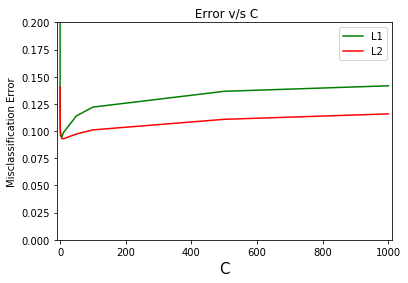

In [18]:
# plotting of L1 and L2 error
def error_vs_c(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title(' Error v/s C')
    plt.plot(x1,y1,'g',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
gscv = OpenFromFile("LR-Uni-Gram")
error_vs_c(gscv)

In [29]:
print(gscv.best_estimator_)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Accuracy on test set: 90.31%
Precision on test set: 92.183
Recall on test set: 96.671
F1-Score on test set: 94.374
Non Zero weights: 38523


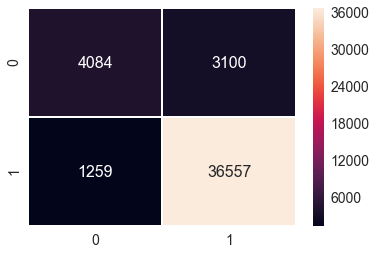

In [32]:
# testing accuracy on the best_estimator

LR = LogisticRegression(C=10,penalty='l2')
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')*100))
print("Non Zero weights:",np.count_nonzero(LR.coef_))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',linewidths=.5)

### Show how sparsity decrease as if we increase the value of C

In [31]:

C_value = [1000,100,10,1,0.1,0.01,0.001,0.0001]
l1_value = ['l1','l1','l1','l1','l1','l1','l1','l1']
def sparsity_increase(i,j):
    LR = LogisticRegression(C=i,penalty=j)
    LR.fit(X_train,y_train)
    y_pred = LR.predict(X_test)
    print("C_value:",i)
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Non Zero weights:",np.count_nonzero(LR.coef_))
    print("-"*100)


for i,j in zip(C_value,l1_value):
    sparsity_increase(i,j)
    
    

C_value: 1000
Accuracy on test set: 86.416%
Non Zero weights: 20158
----------------------------------------------------------------------------------------------------
C_value: 100
Accuracy on test set: 87.867%
Non Zero weights: 15267
----------------------------------------------------------------------------------------------------
C_value: 10
Accuracy on test set: 89.929%
Non Zero weights: 6986
----------------------------------------------------------------------------------------------------
C_value: 1
Accuracy on test set: 90.227%
Non Zero weights: 1376
----------------------------------------------------------------------------------------------------
C_value: 0.1
Accuracy on test set: 88.393%
Non Zero weights: 262
----------------------------------------------------------------------------------------------------
C_value: 0.01
Accuracy on test set: 84.144%
Non Zero weights: 20
----------------------------------------------------------------------------------------------------


    Here we can see that with the increase of C values Non Zero Weight increases, 
    At C_value = 0.001 and 0.0001 and l1 regularizer we get 0 non zero weights. 
    That means sparsity is large and we dont have any non zero value.

### Logistic Regression using RandomSearch cross validation for uni-gram 

In [33]:
%%time
lr = LogisticRegression()

param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = RandomizedSearchCV(lr,param_grid,cv=tscv,verbose=1) 
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR_RandomSearch-Uni-Gram")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.7min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 90.71%
Wall time: 8min 55s


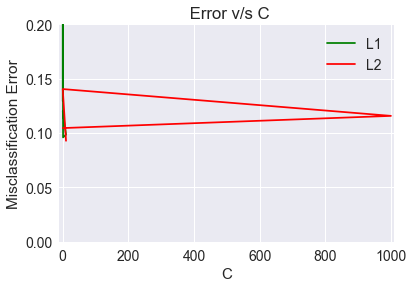

In [36]:
#Function to plot Misclassification error against C
gscv = OpenFromFile("LR_RandomSearch-Uni-Gram")
error_vs_c(gscv)

In [35]:
print(gscv.best_estimator_)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Accuracy on test set: 90.30%
Precision on test set: 92.173
Recall on test set: 96.663
F1-Score on test set: 94.365
Non Zero weights: 38523
Wall time: 9.96 s


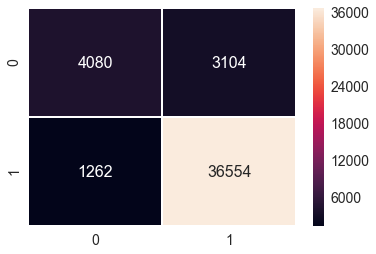

In [48]:
%%time
# testing accuracy on the best_estimator

LR = LogisticRegression(C=10,penalty='l2')
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')*100))
print("Non Zero weights:",np.count_nonzero(LR.coef_))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',linewidths=.5)

### Perturbation Test

In [38]:
lr = LogisticRegression(C= 10, penalty= 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
#print(dir(np))
#print(lr.coef_.size)

Accuracy on test set: 90.313%
Non Zero weights: 38523


In [39]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(lr.coef_[0])[2]
print(weights1[:50])

[ 0.22959955  0.02769383  0.00654113  0.01785463  0.01785463  0.00654113
  0.00299281  0.0106362   0.00634867  0.00495284  0.05463248  0.05619479
  0.00530917 -1.06749079  0.01462368  0.01292867  0.10541176 -0.15542841
  0.11012422  0.19373848  0.00372414  0.00655134  0.17295654  0.00191956
  0.273013    0.12531101 -1.30802224  0.02479664  0.1105268  -0.54594398
  0.07473946 -1.68978546  0.40068942  0.01883747  0.13333569  0.15656358
  0.12240088 -0.54184479  1.07516448 -0.93276758  0.17495965  0.06166258
  0.02739986 -0.54089298  0.37617412 -0.26017884  0.09690935  0.21000545
  0.00319336 -0.73238522]


In [40]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]
#print(X_train_t)
#print(epsilon)

In [41]:
lr = LogisticRegression(C= 10, penalty= 'l2')
lr.fit(X_train_t,y_train)#here is the change
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 90.298%
Non Zero weights: 38523


In [42]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(lr.coef_[0])[2]
print(weights2[:50])

[ 0.24192824  0.03056787  0.00625709  0.02239777  0.02156479  0.00698248
  0.0031956   0.01063307  0.00755919  0.00606763  0.04407813  0.05275686
  0.00651099 -1.09837568  0.01646571  0.0151125   0.10120348 -0.18880752
  0.1153571   0.19401155  0.00399589  0.00644823  0.16108238  0.00185347
  0.29530647  0.13125347 -1.25165252  0.02785464  0.11110793 -0.51293364
  0.06505957 -1.71860612  0.40496988  0.01836217  0.13203888  0.16112345
  0.11684308 -0.55308113  1.02787996 -0.90887936  0.18031506  0.06249739
  0.02555603 -0.54759394  0.31722894 -0.2656791   0.09271546  0.22061393
  0.00298457 -0.73675312]


In [43]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100
#print(weights_diff)

In [44]:
print(weights_diff[np.where(weights_diff > 30)].size)

911


#### weights_diff is 911 , SoThere is  multi collinearity in this data

In [45]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(uni_gram,lr)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-11.9491	worst          				8.5708	awesom         
	-10.4328	tasteless      				8.2752	hook           
	-9.8789	threw          				8.2401	delici         
	-9.8413	undrink        				8.1334	beat           
	-9.7391	disgust        				7.5954	perfect        
	-9.7223	aw             				7.5620	addict         
	-9.2114	horribl        				7.4625	yum            
	-8.7687	yuck           				7.3716	worri          
	-8.7128	terribl        				7.3462	amaz           
	-8.2059	gross          				7.1507	best           
	-7.7484	unapp          				7.0583	heaven         
	-7.6744	unaccept       				6.9828	uniqu          
	-7.6144	disappoint     				6.9683	complaint      
	-7.5041	refund         				6.9484	fantast        
	-7.2512	vomit          				6.8881	yummi          
	-7.2348	rancid         				6.8358	solv           
	-7.1865	skip           				6.7729	excel          
	-7.1184

## Logistic Regression TF-IDF 
#### GridSearch

In [42]:
%%time
X_train, X_test, y_train, y_test = train_test_split(final_150000['clean_text'].values,
                                                    final_150000['Score'].values ,test_size=0.30,shuffle=False)
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (105000, 1308616)
Test Data Size:  (45000, 1308616)
Wall time: 39.1 s


In [76]:
%%time
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = GridSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR-GridSearch-TF-IDF")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 35.3min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l1'}
Best Accuracy: 91.03%
Wall time: 35min 32s


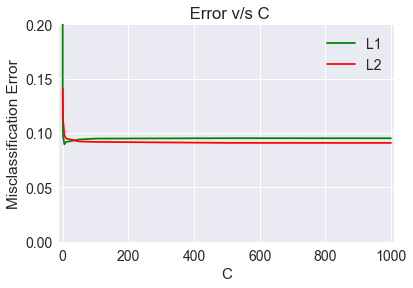

In [77]:
gscv = OpenFromFile("LR-GridSearch-TF-IDF")
error_vs_c(gscv)

In [78]:
print(gscv.best_estimator_)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Accuracy on test set: 91.02%
Precision on test set: 93.320
Recall on test set: 96.197
F1-Score on test set: 94.737
Non Zero weights: 10553


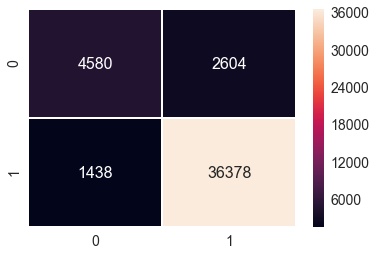

In [86]:
LR = LogisticRegression(C= 5, penalty= 'l1')
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')*100))
print("Non Zero weights:",np.count_nonzero(LR.coef_))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',linewidths=.5)

### Show how sparsity increases as we increase lambda (C=i/lamda) when L1 Regularizer is used

In [15]:
### Show how sparsity increase as if we increase the value of lamba
C_value = [1000,100,10,1,0.1,0.01,0.001,0.0001]
l1_value = ['l1','l1','l1','l1','l1','l1','l1','l1']
def sparsity_increase(i,j):
    lr = LogisticRegression(C=i,penalty=j)
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    print("C_value:",i)
    #print("C_value is: {} and l1_value is: {}".format(i,j))
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Non Zero weights:",np.count_nonzero(lr.coef_))
    print("-"*100)


for i,j in zip(C_value,l1_value):
    sparsity_increase(i,j)

C_value: 1000
Accuracy on test set: 90.209%
Non Zero weights: 31327
----------------------------------------------------------------------------------------------------
C_value: 100
Accuracy on test set: 90.124%
Non Zero weights: 23828
----------------------------------------------------------------------------------------------------
C_value: 10
Accuracy on test set: 90.540%
Non Zero weights: 16784
----------------------------------------------------------------------------------------------------
C_value: 1
Accuracy on test set: 90.442%
Non Zero weights: 1239
----------------------------------------------------------------------------------------------------
C_value: 0.1
Accuracy on test set: 87.358%
Non Zero weights: 131
----------------------------------------------------------------------------------------------------
C_value: 0.01
Accuracy on test set: 83.976%
Non Zero weights: 2
----------------------------------------------------------------------------------------------------


#### Random Search

In [16]:
%%time
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = RandomizedSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR-RandomSearch-TF_IDF")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.3min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 5}
Best Accuracy: 90.87%
Wall time: 7min 30s


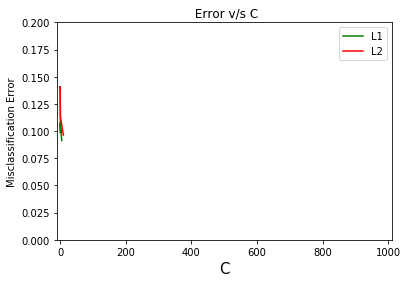

In [19]:
gscv = OpenFromFile("LR-RandomSearch-TF_IDF")
error_vs_c(gscv)

Accuracy on test set: 90.84%
Precision on test set: 93.138
Recall on test set: 96.181
F1-Score on test set: 94.635
Non Zero weights: 10680


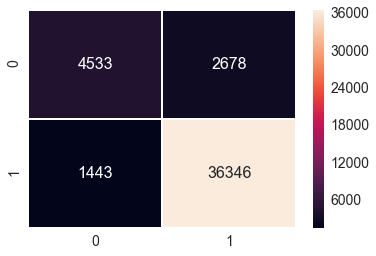

In [20]:
#Testing Accuracy on Test data

LR = LogisticRegression(C= 5, penalty= 'l1')
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)
print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')*100))
print("Non Zero weights:",np.count_nonzero(LR.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',linewidths=.5)

### Perturbation Test

In [57]:
lr = LogisticRegression(C= 10, penalty= 'l1')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 90.600%
Non Zero weights: 15468


In [61]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(lr.coef_[0])[2]
#print(weights1[:50])
weightBefore=weights1[:15000]
#print(len(weightBefore))

In [62]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [63]:
lr = LogisticRegression(C=10, penalty= 'l1')
lr.fit(X_train_t,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 90.631%
Non Zero weights: 15589


In [64]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(lr.coef_[0])[2]
#print(weights2[:50])
weightAfter=weights2[:15000]

In [65]:
weights_diff = (abs(weightAfter - weightBefore)/weightBefore) * 100
print(weights_diff[np.where(weights_diff > 30)].size)

5413


#### hence, weight diff is 5413 So There is  multi collinear!!!!

In [66]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,lr)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-45.4411	two star       				41.2952	high recommend 
	-39.6636	great strength 				36.7070	four star      
	-34.5574	diabet diabet  				32.0839	delici         
	-34.3799	restaur know   				31.1237	good place     
	-34.1253	oat roll       				30.2059	great          
	-33.5921	get came       				29.8564	pleasant surpris
	-33.0516	tri vacuum     				27.8280	initi unpleas  
	-32.9782	sweet adult    				26.5075	wont sorri     
	-31.9411	limb perfect   				25.4264	amaz           
	-31.6336	still energi   				25.2745	perfect        
	-31.4493	cool perfect   				24.9249	best           
	-30.8957	want perfect   				24.2849	old jordan     
	-30.4316	violet flavour 				23.9483	correct mistak 
	-30.1363	worst          				23.8293	could wors     
	-29.9191	still yet      				23.3753	yay            
	-29.5042	fig arriv      				23.3627	wont disappoint
	-29.3385	crunchi littl  			

## Logistic Regression Word2Vec(Avg)

In [67]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final_150000['clean_text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [68]:
len(list_of_sent)

150000

In [69]:
#defining a word2vec model
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    
words=list(w2v_model.wv.vocab)
print(len(words))

15073


In [70]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

150000
50


In [71]:
np.argwhere(np.isnan(sent_vectors))#checking for Nan fields

array([], shape=(0, 2), dtype=int64)

In [73]:
%%time
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train_AvgWord2Vec, X_test, y_train, y_test = train_test_split(sent_vectors,final_150000['Score'].values ,
                                                            test_size=0.30,shuffle=False)

X_train_AvgWord2Vec_final = preprocessing.normalize(X_train_AvgWord2Vec)
print("Train Data Size: ",X_train_AvgWord2Vec_final.shape)

X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (105000, 50)
Test Data Size:  (45000, 50)
Wall time: 406 ms


In [74]:
%%time
lr = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = GridSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train_AvgWord2Vec_final,y_train)
SaveToFile(gscv,"LR-AvgWord2Vec")

print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 10.9min finished


Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Accuracy: 89.06%
Wall time: 11min 3s


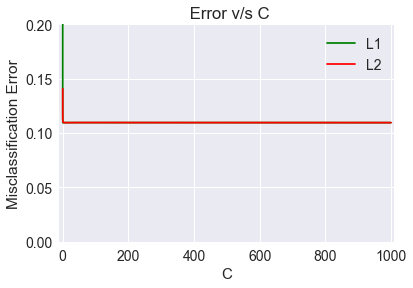

In [75]:
gscv = OpenFromFile("LR-AvgWord2Vec")
error_vs_c(gscv)

In [76]:
print(gscv.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Accuracy on test set: 87.80%
Precision on test set: 89.735
Recall on test set: 96.515
F1-Score on test set: 93.002
Non Zero weights: 50


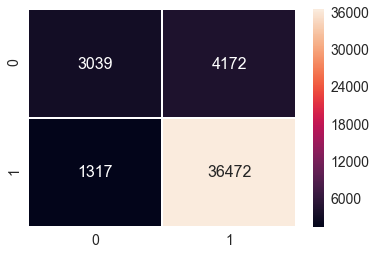

In [80]:
#Testing Accuracy on Test data with best hyper parametrs
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C= 1, penalty= 'l1')
lr.fit(X_train_AvgWord2Vec_final,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g', linewidths=.5)

#### Random Search AvgWord2Vec

In [77]:
%%time
lr = LogisticRegression()

param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 

tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = RandomizedSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train_AvgWord2Vec_final,y_train)

SaveToFile(gscv,"LR-RandomSearch-AvgWord2Vec")

print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.7min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1}
Best Accuracy: 89.06%
Wall time: 4min 55s


In [78]:
print(gscv.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


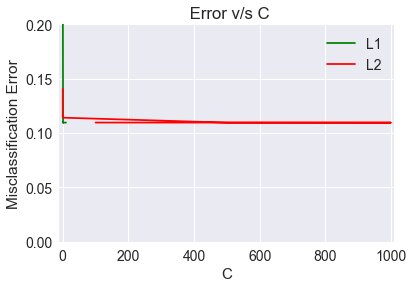

In [81]:
gscv = OpenFromFile("LR-RandomSearch-AvgWord2Vec")
error_vs_c(gscv)

Accuracy on test set: 87.80%
Precision on test set: 89.735
Recall on test set: 96.515
F1-Score on test set: 93.002
Non Zero weights: 50


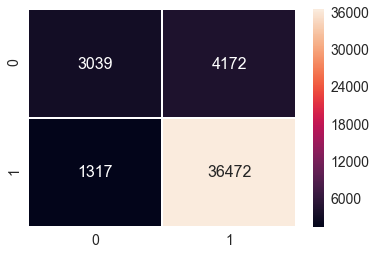

In [82]:
#Testing Accuracy on Test data with best hyper parametrs
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C= 1, penalty= 'l1')
lr.fit(X_train_AvgWord2Vec_final,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',linewidths=.5)

### Perturbation Test

In [84]:
lr = LogisticRegression(C= 5, penalty= 'l1')
lr.fit(X_train_AvgWord2Vec_final,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 87.807%
Non Zero weights: 50


In [85]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(lr.coef_[0])[2]
#print(weights1[:50])
print(len(weights2))

15589


In [87]:
X_train_t = X_train_AvgWord2Vec_final
#Random noise
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [88]:
lr = LogisticRegression(C= 5, penalty= 'l1')
lr.fit(X_train_t,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 87.793%
Non Zero weights: 50


In [89]:
weights2 = find(lr.coef_[0])[2]
print(weights2)

[-4.34900241  1.76867767  0.33333246  3.56636108  0.98012128  0.16709607
 -4.04869947  3.97330242 -4.61906939  0.40257605 -1.04850858 -0.90816507
  0.38303954  0.5806754   1.38053741 -2.80995933  0.3570581   1.75204251
  1.92276095  2.03041835  2.11604545 -0.68989182 -1.9768246  -0.15844519
 -0.64091827 -0.93381869 -1.40893477 -2.99523926 -4.38236244 -1.88402074
  1.81451336 -3.87562687  2.22155458  1.22219157  0.58076664  0.35743328
 -0.54735218 -0.34273084 -1.86643012  1.26418634  0.67847357 -2.07620699
  4.64500318 -0.39806912 -0.46781577 -0.11230673  4.39662317  0.11197016
  0.88200796 -2.39472743]


In [90]:
weights_diff = (abs(weights2 - weights1)/weights1) * 100
print(weights_diff[np.where(weights_diff > 30)].size)

1


### We can see weightdiff is 1 , So its means theres is no multi Collinearity

In [91]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,lr)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-4.6191	aaaaaahhhhhyaaaaaa				4.6450	aarrgghhhh     
	-4.3824	aaf            				4.3966	ab             
	-4.3490	aaa            				3.9733	aaaaaaarrrrrggghhh back
	-4.0487	aaaaaaarrrrrggghhh				3.5664	aaa job        
	-3.8756	aafco approv   				2.2216	aafco dog      
	-2.9952	aadp           				2.1160	aaahhh sale    
	-2.8100	aaaah favorit  				2.0304	aaahhh         
	-2.3947	ab one         				1.9228	aaah tast      
	-2.0762	aah rest       				1.8145	aafco          
	-1.9768	aaahhhhhh drink				1.7687	aaa aaa        
	-1.8840	aaf hair       				1.7520	aaah miss      
	-1.8664	aah coffe      				1.3805	aaaah          
	-1.4089	aachen munich  				1.2642	aah handsom    
	-1.0485	aaaaah         				1.2222	aafco larg     
	-0.9338	aachen         				0.9801	aaa spelt      
	-0.9082	aaaaah satisfi 				0.8820	ab fine        
	-0.6899	aaahhhhhh      				0.6785	aah order   

### Logistic Regression TF-IDF Word2Vec
#### GridSearch

In [92]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
#final_20000 = final_50000.head(20000)
for sent in final_150000['clean_text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)


In [93]:
%%time
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))   

150000
50
Wall time: 34.9 s


In [94]:
np.argwhere(np.isnan(tfidf_sent_vectors))#checking for NaN values

array([[     0,      0],
       [     0,      1],
       [     0,      2],
       ...,
       [149999,     47],
       [149999,     48],
       [149999,     49]], dtype=int64)

In [95]:
#Not shuffling the data as we want it on time basis
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors,final_150000['Score'].values,
                                                    test_size=0.3,shuffle=False)

In [96]:
#resolving NaN issue
X_train=np.isnan(X_train)#for solving NaN issue
np.where(np.isnan(X_train))
np.nan_to_num(X_train)
X_test=np.isnan(X_test)
np.where(np.isnan(X_test))
np.nan_to_num(X_test)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [97]:
print(np.argwhere(np.isnan(X_train)))#checking for NaN values
print(np.argwhere(np.isnan(X_test)))#checking for NaN values
print("We have Resolved the Nan Issue")

[]
[]
We have Resolved the Nan Issue


In [98]:
%%time
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = GridSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR GridSearch TF_IDF-WORD2VEC")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.6min finished


Best HyperParameter:  {'C': 1000, 'penalty': 'l1'}
Best Accuracy: 85.92%
Wall time: 3min 39s


In [99]:
print(gscv.best_estimator_)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


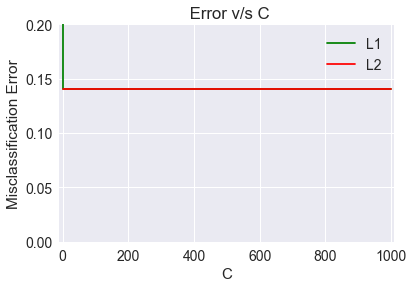

In [100]:
gscv = OpenFromFile("LR GridSearch TF_IDF-WORD2VEC")
error_vs_c(gscv)

Accuracy on test set: 83.98%
Precision on test set: 83.976
Recall on test set: 100.000
F1-Score on test set: 91.290
Non Zero weights: 4


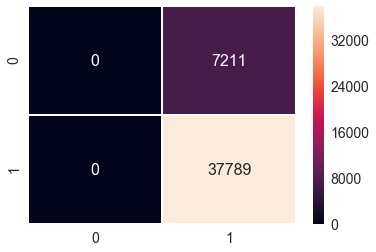

In [104]:
lr = LogisticRegression(C= 1000, penalty= 'l1')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',linewidths=.5)

#### RandomizedSearchCV

In [101]:
%%time
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = RandomizedSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR RandomSearch TF_IDF-WORD2VEC")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 85.92%
Wall time: 1min 19s


In [102]:
print(gscv.best_estimator_)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


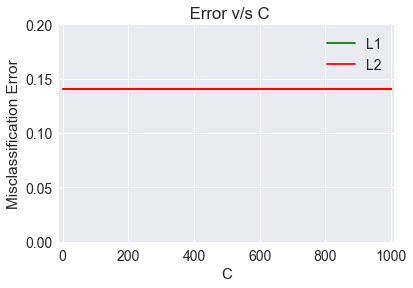

In [103]:
gscv = OpenFromFile("LR RandomSearch TF_IDF-WORD2VEC")
error_vs_c(gscv)

Accuracy on test set: 83.98%
Precision on test set: 83.976
Recall on test set: 100.000
F1-Score on test set: 91.290
Non Zero weights: 50


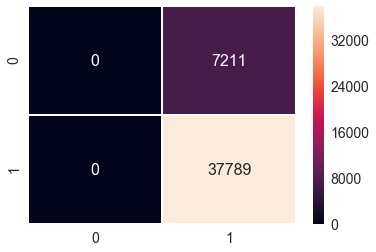

In [105]:
lr = LogisticRegression(C= 10, penalty= 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',linewidths=.5)

### Perturbation Test

In [119]:
lr = LogisticRegression(C= 100, penalty= 'l1')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 83.976%
Non Zero weights: 5


In [120]:
weights1 = find(lr.coef_[0])[2]
print(weights1[:50])

[3.41568429e-01 4.44866533e-02 7.25809153e-04 1.16931923e-12
 1.45051390e+00]


In [121]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [122]:
lr = LogisticRegression(C= 100, penalty= 'l1')
lr.fit(X_train_t,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 83.976%
Non Zero weights: 5


In [123]:
weights2 = find(lr.coef_[0])[2]
print(weights2[:50])

[3.41568429e-01 1.45051390e+00 7.25809153e-04 1.16931923e-12
 4.44866533e-02]


In [124]:
weights_diff = (abs(weights2 - weights1)/weights1) * 100

In [125]:
 print(weights_diff[np.where(weights_diff > 30)].size)

2


#### We can see weightdiff is 2 , So its means theres is no multi Collinearity

In [126]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,lr)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	0.0000	aaa            				1.4505	aaahhh sale    
	0.0000	aaa aaa        				0.3416	aaaaaahhhhhyaaaaaa fire
	0.0000	aaa hockey     				0.0445	aarthur whole  
	0.0000	aaa job        				0.0007	aafco          
	0.0000	aaa spelt      				0.0000	aah            
	0.0000	aaaaaaaaagghh  				0.0000	ab one         
	0.0000	aaaaaaarrrrrggghhh				0.0000	ab fine        
	0.0000	aaaaaaarrrrrggghhh back				0.0000	ab diet        
	0.0000	aaaaaahhhhhyaaaaaa				0.0000	ab             
	0.0000	aaaaah         				0.0000	aarthur        
	0.0000	aaaaah satisfi 				0.0000	aarrgghhhh yorkiex
	0.0000	aaaaahhhhhhhhhhhhhhhh				0.0000	aarrgghhhh     
	0.0000	aaaaahhhhhhhhhhhhhhhh angel				0.0000	aah rest       
	0.0000	aaaah          				0.0000	aah order      
	0.0000	aaaah favorit  				0.0000	aah handsom    
	0.0000	aaah           				0.0000	aah coffe      
	0.0000	aaah miss      				0.0000	

### Analysis of Logistic Regression Model on 150k data points

| Feature | Algoritms      | Accuracy | Precision | Recall|F1- Scores |Best Value for C| Penalty    |
| ------- | ---------      | -------- | --------- | ------|-----------|--------------- |------------|
| BOW     | GridSearchCV   | 90.31    | 92.183    | 96.671|94.376     |  C=10          | penalty='l2'|
| BOW     | RandomSearchCV | 90.30    | 92.173    | 96.663|94.365     |  C=10          | penalty='l2'|
|TF-IDF   |GridSearchCV    |91.02     | 93.320    | 96.197|94.737     |  C=5           | penalty='l1'|
|TF-IDF   |RandomSearchCV  |90.84     | 93.138    | 96.181|94.635     |  C=5           | penalty='l1'|
|Word2Vec |GridSearchCV    |87.80     | 89.735    | 96.515|93.002     |  C=1           | penalty='l1'|
|Word2Vec |RandomSearchCV  |87.80     | 89.735    | 96.515|93.002     |  C=1           | penalty='l1'|
|TFIDF W2V|GridSearchCV    |83.98     | 83.976    | 100   |91.290     |  C=1000        | penalty='l1'|
|TFIDF W2V|RandomSearchCV  |83.98     | 83.976    | 100   |91.290     |  C=10          | penalty='l2'|


### Observation
    - We did Bow,tf-idf,AvgWord2vec,and tfidf-word2vec on data points.
    - TF-IDF using GridSearch has highest accuracy among all of them.
    - We see that when C decreases (or lambda increases) the sparsity increases drastically,
      that mean L1 regularizer increase the sparsity in Logistic Regression.
    - Multicolinearity is exits in this model.